In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bisect
from sklearn.preprocessing import *

# dist_measure
# 1 = Euclidean Distance
# 2 = Perpendicular Distance
# 3 = Vertical Distance
def find_pips(data: np.array, n_pips: int, dist_measure: int):
    pips_x = [0, len(data) - 1]  # Index
    pips_y = [data[0], data[-1]] # Price

    for curr_point in range(2, n_pips):
        md = 0.0 # Max distance
        md_i = -1 # Max distance index
        insert_index = -1
        # Use a single loop to iterate over all the points
        for i in range(1, len(data) - 1):
            left_adj = bisect.bisect_right(pips_x, i) - 1
            right_adj = left_adj + 1
            # Calculate the distance from the point to the line segment
            d = distance(data, pips_x, pips_y, i, left_adj, right_adj, dist_measure)
            # Update the maximum distance and the insert index
            if d > md:
                md = d
                md_i = i
                insert_index = right_adj
        # Insert the new pip
        pips_x.insert(insert_index, md_i)
        pips_y.insert(insert_index, data[md_i])
    return pips_x, pips_y

# Define a helper function to calculate the distance
def distance(data, pips_x, pips_y, i, left_adj, right_adj, dist_measure):
    time_diff = pips_x[right_adj] - pips_x[left_adj]
    price_diff = pips_y[right_adj] - pips_y[left_adj]
    slope = price_diff / time_diff
    intercept = pips_y[left_adj] - pips_x[left_adj] * slope
    dist_funcs = {
        1: lambda x, y: ( (pips_x[left_adj] - x) ** 2 + (pips_y[left_adj] - y) ** 2 ) ** 0.5 + ( (pips_x[right_adj] - x) ** 2 + (pips_y[right_adj] - y) ** 2 ) ** 0.5, # Euclidean distance
        2: lambda x, y: abs( (slope * x + intercept) - y ) / (slope ** 2 + 1) ** 0.5, # Perpendicular distance
        3: lambda x, y: abs( (slope * x + intercept) - y ) # Vertical distance
    }
    return dist_funcs[dist_measure](i, data[i])

In [ ]:

data = pd.read_csv("/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data/GBP_USD_M15_raw_data.csv", parse_dates=['time'])
data = data.set_index('time')

# take data from 2007 to 2014
data = data['2007-01-01':'2008-01-01']

# add new columns from the time column, year, month, day, hour, minute
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['minute'] = data.index.minute
data

In [ ]:
n_close_points = 24
n_perc_points = 4
dist_measure = 1
pips_y_list = []
future_candles = 10
# loop through the data
# start from the 24th point
for index in range(n_close_points, len(data)):
    try:
        x = data['close'].iloc[index-n_close_points:index].to_numpy()
        pips_x, pips_y = find_pips(x, n_perc_points, dist_measure)
        scaled_pips_y = StandardScaler().fit_transform(np.array(pips_y).reshape(-1, 1)).reshape(-1)
        pips_y_dict = {f'pip_{i}': scaled_pips_y[i] for i in range(n_perc_points)}
        j = index - 1
        pips_y_dict['year'] = data['year'].iloc[j]
        pips_y_dict['month'] = data['month'].iloc[j]
        pips_y_dict['day'] = data['day'].iloc[j]
        pips_y_dict['hour'] = data['hour'].iloc[j]
        pips_y_dict['minute'] = data['minute'].iloc[j]
        pips_y_dict['close'] = data['close'].iloc[j]
        pips_y_dict['future_close'] = data['close'].iloc[j+future_candles]
        pips_y_dict['future_return'] = pips_y_dict['future_close'] - pips_y_dict['close']
        pips_y_dict['future_log_ratio'] = 2500 * np.log(pips_y_dict['future_close'] / pips_y_dict['close'])
        pips_y_dict['current_log_ratio'] = 2500 * np.log(pips_y_dict['close'] / data['close'].iloc[j-1])
        pips_y_list.append(pips_y_dict)
    except:
        print('An exception occurred')
        break
    # print(scaled_pips_y)
    # pd.Series(x).plot()
    # for i in range(n_perc_points):
    #     plt.plot(pips_x[i], pips_y[i], marker='o', color='red')
    # plt.plot(pips_x, pips_y, color='black')
    # plt.show()
# pips_y_df = pd.DataFrame(pips_y_list, columns=[f'pip_{i}' for i in range(n_perc_points)])
# pips_y_df_np = pips_y_df.to_numpy()

In [ ]:
import pandas as pd
pips_y_df = pd.DataFrame(pips_y_list)
pips_y_df

In [ ]:
# plot the histogram
pips_y_df.hist(bins=100)

In [ ]:
pips_y_df

In [ ]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d 
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans

np.random.seed(5)

# X = pips_y_df_np
X = pips_y_df_np[:700]

estimators = [
    ("k_means_24", KMeans(n_clusters=24)),
    ("k_means_3", KMeans(n_clusters=3)),
    ("k_means_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fig = plt.figure(figsize=(13, 10))
titles = ["24 clusters", "3 clusters", "3 clusters, bad init"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_
    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(float), edgecolor="k")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("p0")
    ax.set_ylabel("p1")
    ax.set_zlabel("p2")
    ax.set_title(title)

# plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

In [367]:
np.random.seed(5)

# standard scale the 'hour', 'minute', 'current_log_ratio' columns
pips_y_df[['hour', 'minute', 'current_log_ratio']] = StandardScaler().fit_transform(pips_y_df[['hour', 'minute', 'current_log_ratio']])
pips_y_df_np = pips_y_df[['pip_0', 'pip_1', 'pip_2', 'pip_3', 'hour', 'minute', 'current_log_ratio']].to_numpy()
est = KMeans(n_clusters=36)
est.fit(pips_y_df_np)
labels = est.labels_

In [368]:
# add a new column namely k_label using labels to pips_y_df
pips_y_df['k_label'] = labels
test_pips_y_df = pips_y_df.copy()
test_pips_y_df['k_label_1'] = test_pips_y_df['k_label'].shift(1)
test_pips_y_df = test_pips_y_df.dropna()
test_pips_y_df

,pip_0,pip_1,pip_2,pip_3,year,month,day,hour,minute,close,future_close,future_return,future_log_ratio,current_log_ratio,k_label,k_label_1
1,-1.660483,0.094141,0.723081,0.843261,2007,1,2,-1.243586,0.445845,1.96545,1.96576,0.00031,0.394281,-0.233544,13,31.0
2,-1.327838,-0.600032,0.867848,1.060022,2007,1,2,-1.243586,1.340075,1.96562,1.96578,0.00016,0.203490,0.196806,27,13.0
3,-1.684634,0.652694,0.196948,0.834992,2007,1,2,-1.099624,-1.342616,1.96543,1.96533,-0.00010,-0.127202,-0.221916,12,27.0
4,-1.481763,-0.314121,0.682182,1.113702,2007,1,2,-1.099624,-0.448386,1.96583,1.96428,-0.00155,-1.971955,0.464300,31,12.0
5,-1.489661,-0.316913,0.747373,1.059202,2007,1,2,-1.099624,0.445845,1.96561,1.96612,0.00051,0.648569,-0.256784,13,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25333,1.459740,-1.232164,-0.516924,0.289347,2007,12,31,1.347731,1.340075,1.98494,1.98670,0.00176,2.215710,-1.255978,24,16.0
25334,1.421377,-0.395783,-1.318130,0.292535,2007,12,31,1.491693,-1.342616,1.98494,1.98905,0.00411,5.171127,-0.000923,2,24.0
25335,-0.015604,-1.270133,-0.240296,1.526033,2008,1,1,0.915844,0.445845,1.98591,1.98940,0.00349,4.389596,1.115995,2,2.0
25336,0.278112,-1.350610,-0.336500,1.408998,2008,1,1,1.203769,0.445845,1.98592,1.98876,0.00284,3.572615,0.010589,2,2.0


In [379]:
test_pips_y_df = test_pips_y_df[(test_pips_y_df['future_log_ratio'] < 6) & (test_pips_y_df['future_log_ratio'] > -6)]
k_label_log_ratio = test_pips_y_df.groupby('k_label')['future_log_ratio'].sum().sort_values(ascending=False)
k_label_log_ratio

k_label
31    312.846151
24    252.132046
19    240.815532
33    205.176226
1     196.290756
27    190.440759
10    183.399116
6     151.681061
25    145.360206
13    144.461042
35    131.187896
28    129.850850
26    126.432877
34    126.395373
11    122.691468
14    119.421922
17    106.165115
3      97.423317
0      53.062189
5      52.000454
32     49.169739
15     43.722920
12     35.582036
30     18.798419
7       6.542318
22    -32.218353
4     -37.533027
20    -43.440083
8     -54.155475
9     -59.264303
16    -62.566328
29    -71.096422
18    -96.077054
23   -151.408135
2    -185.454305
21   -189.283876
Name: future_log_ratio, dtype: float64

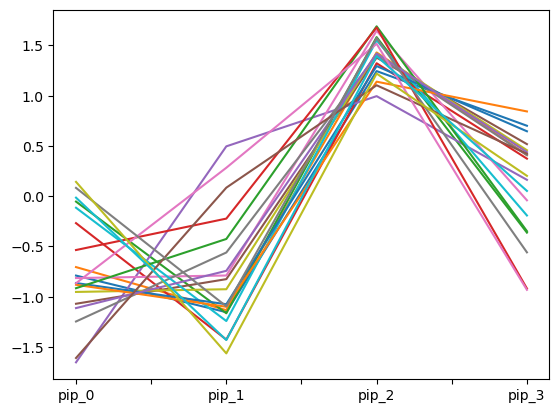

In [381]:
k_label_26 = test_pips_y_df[test_pips_y_df['k_label'] == 28]
# plot pip_0, pip_1, pip_2 and pip_3 where the k_label is 26

# loop through all the rows of k_label_26 and plot pip_0, pip_1, pip_2 and pip_3
for i in range(20):
    k_label_26.iloc[i][['pip_0', 'pip_1', 'pip_2', 'pip_3']].plot()
    
plt.show()


RandomForestRegressor


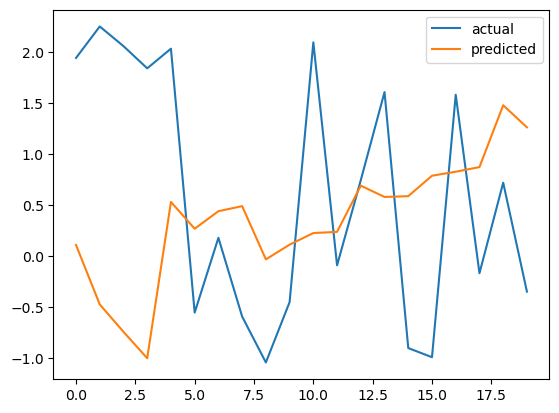

2.35106559458087
-0.6824567842601834


In [323]:


# create X_train, X_test and y_train, y_test
# take first 100 rows from test_pips_y_df
test_pips_y_df = test_pips_y_df[:200]
X = test_pips_y_df[['pip_0', 'pip_1', 'pip_2', 'pip_3', 'hour', 'minute', 'k_label',  'k_label_1', 'current_log_ratio']].to_numpy()
y = test_pips_y_df['future_log_ratio'].to_numpy()


# X = test_pips_y_df[['pip_0', 'pip_1', 'pip_2', 'pip_3']].to_numpy()
# y = test_pips_y_df['future_return'].to_numpy()

# split the data into train and test
split = 0.9
split_index = int(len(X) * split)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

# create a linear regression model
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.ensemble import *

print("RandomForestRegressor")
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# plot the predicted and actual values
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='predicted')
plt.legend()
plt.show()

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)
print(r2)
